In [3]:
import os
from anthropic import Anthropic
from dotenv import load_dotenv

load_dotenv()
anthropic_api_key = os.getenv('ANTHROPIC_API_KEY')
os.environ['ANTHROPIC_API_KEY'] = anthropic_api_key
if anthropic_api_key:
    print(f"ANTHROPIC_API_KEY Key exists and begins {anthropic_api_key[:8]}")
else:
    print("ANTHROPIC_API_KEYKey not set")

client = Anthropic()
MODEL_NAME="claude-3-5-sonnet-20241022"

ANTHROPIC_API_KEY Key exists and begins sk-ant-a


**Real-World Prompting Tips
1. Prompt templates: insert the variant text and situation with variables 
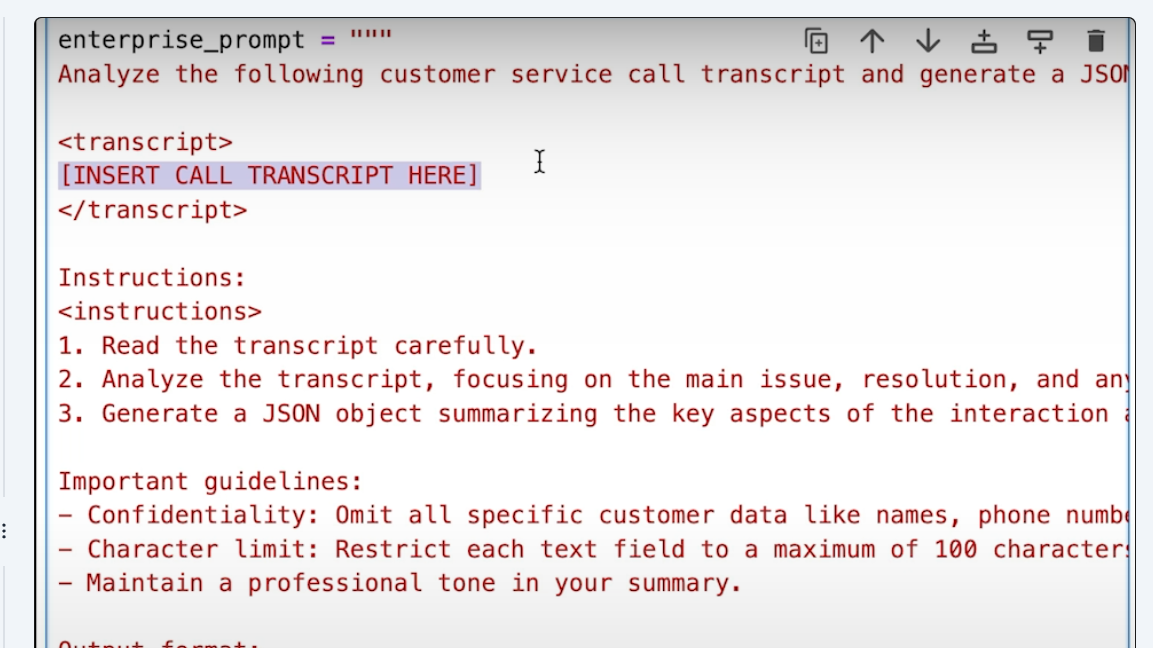
- Let Claude think: chain of thought: think out loud and output that
- Be clear and direct
- Use prompt templates
- Give the model a role
- Structure prompts with XML: 
- Chain complex prompts
- Use examples: multi-shot prompting
µ

1. setting_the_role =   
    "You are ... 
    Your task is...
    Please follow the following instructions carefully:"
2. instruction_pt1= """
  <customer_review>
    {{CUSTOMER_REVIEW}}
  </customer_review>            ### not mandatory to use xml tags, but Claude models seem to work much better with xml tags
"""

### 1. Setting the Role

In [4]:
setting_the_role = """
You are an AI assistant specialized in analyzing customer reviews. 
Your task is to determine the overall sentiment of a given review 
and extract any specific complaints mentioned. 
Please follow these instructions carefully:
"""

### 2. Make it a Prompt template

In [5]:
instruction_pt1 = """
1. Review the following customer feedback:

<customer_review>
{{CUSTOMER_REVIEW}}
</customer_review>
"""

### 3. Let Claude Think

In [6]:
instruction_pt2 = """
2. Analyze the review using the following steps. 
Show your work in <review_breakdown> tags:

a) Key Phrase Extraction:
   - Extract and quote key phrases that indicate sentiment 
   (positive, negative, or neutral).
   - Extract and quote key phrases that suggest complaints or issues.

b) Sentiment Analysis:
   - Consider arguments for positive, negative, 
   and neutral sentiment based on the extracted phrases.
   - Determine the overall sentiment (positive, negative, or neutral) 
   based on your analysis.
   - Explain your reasoning for the sentiment classification.

c) Complaint Extraction:
   - List each specific issue or problem mentioned in the review.
   - For each complaint, provide the relevant quote from the review.
   - Count the total number of complaints found.

It's OK for this section to be quite long as you 
thoroughly break down the review.
"""

### 4. Output Instructions

In [7]:
instruction_pt3 = """
3. Based on your analysis, 
generate a JSON output with the following structure:

<json>
{
  "sentiment_score": "Positive|Negative|Neutral",
  "sentiment_analysis": "Explanation of sentiment classification",
  "complaints": [
    "Complaint 1",
    "Complaint 2",
    "..."
  ]
}
</json>

If no complaints are found, 
use an empty array for the "complaints" field.

Remember:
- Base your analysis solely on the content of the provided review.
- Do not make assumptions or include information not present in the review.
- Be objective and focus on the customer's expressed opinions and experiences.
- Ensure your JSON output is properly formatted and contains all required fields.
"""

In [8]:
final_prompt = f"""
{setting_the_role}
{instruction_pt1}
{instruction_pt2}
{instruction_pt3}
"""
print(final_prompt)




You are an AI assistant specialized in analyzing customer reviews. 
Your task is to determine the overall sentiment of a given review 
and extract any specific complaints mentioned. 
Please follow these instructions carefully:


1. Review the following customer feedback:

<customer_review>
{{CUSTOMER_REVIEW}}
</customer_review>


2. Analyze the review using the following steps. 
Show your work in <review_breakdown> tags:

a) Key Phrase Extraction:
   - Extract and quote key phrases that indicate sentiment 
   (positive, negative, or neutral).
   - Extract and quote key phrases that suggest complaints or issues.

b) Sentiment Analysis:
   - Consider arguments for positive, negative, 
   and neutral sentiment based on the extracted phrases.
   - Determine the overall sentiment (positive, negative, or neutral) 
   based on your analysis.
   - Explain your reasoning for the sentiment classification.

c) Complaint Extraction:
   - List each specific issue or problem mentioned in the revie

In [9]:
import re
def get_review_sentiment(review):
    #Insert the context into the prompt
    prompt = final_prompt.replace("{{CUSTOMER_REVIEW}}", review)
    # Send a request to Claude
    response = client.messages.create(
        model=MODEL_NAME,
        max_tokens=2000,
        messages=[
            {"role": "user", "content": prompt}        
        ]
    )
    output = response.content[0].text
    print("ENTIRE MODEL OUTPUT: ")
    print(output)
    
    sentiment = re.search(r'<json>(.*?)</json>', output, re.DOTALL)
    
    if sentiment:
        print("FINAL JSON OUTPUT: ")
        print(sentiment.group(1).strip())
    else:
        print("No sentiment analysis in the response.")

In [10]:
review1 = """
I am in love with my Acme phone.  It's incredible.
It's a little expensive, but so worth it imo.
If you can afford it, it's worth it! 
I love the colors too!
"""

In [11]:
get_review_sentiment(review1)

ENTIRE MODEL OUTPUT: 
<review_breakdown>

a) Key Phrase Extraction:

Positive sentiment phrases:
- "in love with"
- "incredible"
- "so worth it"
- "worth it!"
- "I love the colors"

Potential concern/negative phrases:
- "a little expensive"

b) Sentiment Analysis:

Arguments for positive sentiment:
- Multiple expressions of strong positive emotions ("in love", "love")
- Use of enthusiastic language ("incredible")
- Repeated emphasis on value ("worth it" stated twice)
- Positive commentary about aesthetics (colors)
- Even the price concern is immediately qualified with positive justification

Arguments for negative sentiment:
- Minor price concern mentioned

Arguments for neutral sentiment:
- None significant

Overall Sentiment: POSITIVE
Reasoning: The review is overwhelmingly positive with multiple strong positive expressions. The single negative point (price) is immediately countered by the reviewer themselves stating it's "worth it" twice. The enthusiasm and multiple positive aspects

In [12]:
review2 = """
I recently bought the ABC Smartwatch, and I have to say, it's been a 
bit of a rollercoaster. Let's start with the good stuff - 
the design is absolutely gorgeous. It's sleek, lightweight, 
and looks fantastic on my wrist. The display is crisp and bright, 
even in direct sunlight. I also love how customizable the watch 
faces are, allowing me to switch up the look whenever I want.
However, there are some significant downsides that I can't ignore. 
The battery life is terrible - I'm lucky if I get through a full 
day without needing to charge it. This is especially frustrating
when I'm traveling or out for long periods. The fitness tracking 
features, which were a big selling point for me, are hit or miss. 
It often doesn't accurately count my steps or calculate calories burned 
during workouts. Another issue I've encountered is with the touch 
sensitivity. Sometimes it's overly sensitive, registering accidental 
touches, while other times I have to tap multiple times for it to 
respond. It's inconsistent and annoying, especially when I'm trying to 
quickly check notifications or start a workout.On the plus side, the 
integration with my smartphone is seamless, and I appreciate being able 
to respond to texts and calls from my wrist. The water resistance has 
also held up well - I've worn it while swimming without any problems.
Customer service has been decent. They were quick to respond when I 
reported the battery issue, but their solution of turning off certain 
features defeats the purpose of having a smartwatch. All in all, while 
there are aspects of the ABC Smartwatch that I really like, the battery 
life and inconsistent performance are major drawbacks. For the price 
point, I expected better. It's not worth your money.
"""

In [13]:
get_review_sentiment(review2)

ENTIRE MODEL OUTPUT: 
<review_breakdown>

a) Key Phrase Extraction:

Positive Phrases:
- "design is absolutely gorgeous"
- "sleek, lightweight, and looks fantastic"
- "display is crisp and bright"
- "love how customizable the watch faces are"
- "integration with my smartphone is seamless"
- "water resistance has held up well"
- "customer service has been decent"
- "quick to respond"

Negative Phrases:
- "battery life is terrible"
- "lucky if I get through a full day"
- "fitness tracking features are hit or miss"
- "doesn't accurately count my steps"
- "touch sensitivity... inconsistent and annoying"
- "not worth your money"
- "major drawbacks"
- "expected better"

b) Sentiment Analysis:
The review shows a mixed sentiment but ultimately leans negative. While there are several positive aspects mentioned about the design and basic functionality, the reviewer concludes that the product is "not worth your money" and has "major drawbacks." The critical issues (battery life, fitness tracking,